In [1]:
import torch 
import matplotlib.pyplot as plt 
#from lanczos import lanczos 
#torch.set_num_threads(1)
torch.manual_seed(42)

In [3]:
d = 2 # fixed
D = 20
dtype = torch.float64
#Lancsize = 100 

B = 0.01* torch.randn(d, D, D, dtype=dtype)
#symmetrize initial boundary PEPS
B = (B + B.permute(0, 2, 1))/2.
A = torch.nn.Parameter(B.view(d, D**2))

#dimer covering
T = torch.zeros(d, d, d, d, dtype=dtype)
T[0, 0, 0, 1] = 1.0 
T[0, 0, 1, 0] = 1.0 
T[0, 1, 0, 0] = 1.0 
T[1, 0, 0, 0] = 1.0 
T = T.view(d, d**2, d)

optimizer = torch.optim.LBFGS([A], max_iter=20, tolerance_grad=0, tolerance_change=0, line_search_fn="strong_wolfe")

In [3]:
def symmetrize(A):
    Asymm = A.view(d, D, D) 
    Asymm = (Asymm + Asymm.permute(0, 2, 1))/2
    return Asymm.view(d, D**2)

def closure():
    optimizer.zero_grad()
    Asymm = symmetrize(A)
    T1 = torch.einsum('xa,xby,yc',(Asymm,T,Asymm)).view(D,D,d,d,D,D).permute(0,2,4,1,3,5).contiguous().view(D**2*d, D**2*d)
    T2 = torch.einsum('xa,xb',(Asymm,Asymm)).view(D,D,D,D).permute(0,2,1,3).contiguous().view(D**2,D**2)

    #phi0 = torch.randn(D**2*d)
    #phi0 = phi0/phi0.norm()
    #eigval_1, _ = lanczos(lambda x: T1@x, phi0, Lancsize)

    #phi0 = torch.randn(D**2)
    #phi0 = phi0/phi0.norm()
    #eigval_2, _ = lanczos(lambda x: T2@x, phi0, Lancsize)

    eigval_1,_ = torch.symeig(T1,eigenvectors=True)
    eigval_2,_ = torch.symeig(T2,eigenvectors=True)

    lnT = torch.log(eigval_1.max())
    lnZ = torch.log(eigval_2.max())
    loss = -lnT + lnZ
    loss.backward()
    return loss

epoch, residual entropy 0 0.032520854062758175 -0.8884594826789323
epoch, residual entropy 1 0.29055531845437166 -0.003448972519403189
epoch, residual entropy 2 0.29128559821582556 -0.000944247944074323
epoch, residual entropy 3 0.2914547684393538 -0.0003640253517879178
epoch, residual entropy 4 0.2914882351238006 -0.0002492408111047316
epoch, residual entropy 5 0.2915100333773619 -0.000174476831221817
epoch, residual entropy 6 0.29152400030567005 -0.0001265728491840574
epoch, residual entropy 7 0.2915290272311859 -0.00010933142398992467
epoch, residual entropy 8 0.2915329888580249 -9.574377631607227e-05
epoch, residual entropy 9 0.29153637811684785 -8.411924512403068e-05
epoch, residual entropy 10 0.2915399738318447 -7.178660742284425e-05
epoch, residual entropy 11 0.2915421321806999 -6.438386986240358e-05
epoch, residual entropy 12 0.29154349655936596 -5.9704303269872156e-05
epoch, residual entropy 13 0.2915450970328468 -5.421497510927583e-05
epoch, residual entropy 14 0.291546471018

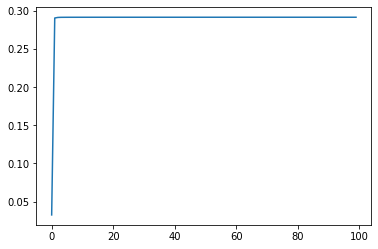

In [4]:
exact = 0.2915609040 
Nepoch = 100 
F=[]
for epoch in range(Nepoch):
    loss = optimizer.step(closure) # closure is used to calculate the loss
    F.append(-loss.item())
    print ('epoch, residual entropy', epoch, -loss.item(), (-loss.item()-exact)/exact)
plt.plot(range(Nepoch),F)
plt.show()